# Deep Image Neural Net w/ CIFAR10

I only trained each model to 10 epochs because I have limited hardware and time, but that's usually enough to tell when one model is clearly beating another.

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms.v2 as T
import matplotlib.pyplot as plt

toTensor = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)])

train_and_valid_data = torchvision.datasets.CIFAR10(
    root="datasets", train=True, download=True, transform=toTensor
)
test_data = torchvision.datasets.CIFAR10(
    root="datasets", train=False, download=True, transform=toTensor
)

train_data, valid_data = torch.utils.data.random_split(
    train_and_valid_data, [45000, 5000]
)
device = "cuda"

100%|██████████| 170M/170M [00:04<00:00, 34.9MB/s] 


In [2]:
def eval(model, criterion, test_loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
            _, predicted = torch.max(y_pred, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [3]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3*32*32, 100), nn.SiLU(),
    nn.Linear(100,100), nn.SiLU(),
    nn.Linear(100,100), nn.SiLU(),
    nn.Linear(100,100), nn.SiLU(),
    nn.Linear(100,100), nn.SiLU(),
    nn.Linear(100,10)
)
for idx, module in model.named_modules():
    if isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight)
        nn.init.zeros_(module.bias)

device = "cuda"

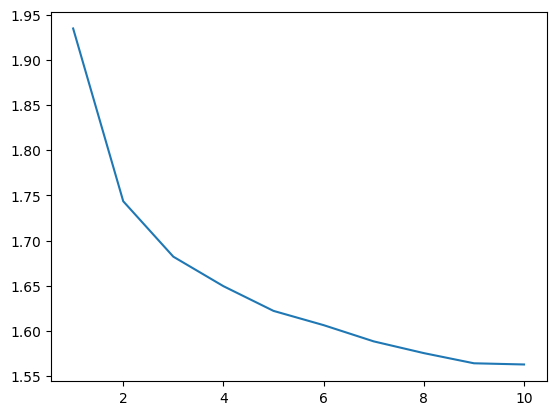

In [4]:
def train(model, optimizer, criterion, train_loader, n_epochs):
    model.train()
    loss_epochs = []
    for epoch in range(1, n_epochs+1):
        total_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            total_loss+=loss.item()
            optimizer.step()
            optimizer.zero_grad()
        loss_epochs.append((epoch, total_loss/len(train_loader)))
    return loss_epochs

model.to(device)
lr = .003
optimizer = torch.optim.NAdam(model.parameters(), lr=lr)
xentropy = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
losses = train(model, optimizer, xentropy, train_loader, 10)
plt.plot([x[0] for x in losses], [x[1] for x in losses])
plt.show()

In [5]:
# Evaluation of Model 1 
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True)
loss, accuracy = eval(model, xentropy, valid_loader)
print("Model 1 Loss:", loss)
print("Model 1 Accuracy:", accuracy)

Model 1 Loss: 1.6073620304180558
Model 1 Accuracy: 0.4318


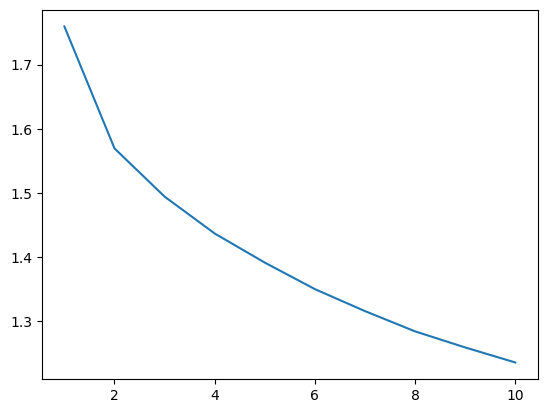

In [6]:
# Same model, but with batch norm

model2 = nn.Sequential(
    nn.Flatten(),
    nn.BatchNorm1d(3*32*32), nn.Linear(3*32*32, 100), nn.SiLU(),
    nn.BatchNorm1d(100), nn.Linear(100,100), nn.SiLU(),
    nn.BatchNorm1d(100), nn.Linear(100,100), nn.SiLU(),
    nn.BatchNorm1d(100), nn.Linear(100,100), nn.SiLU(),
    nn.BatchNorm1d(100), nn.Linear(100,100), nn.SiLU(),
    nn.Linear(100,10)
)
for idx, module in model2.named_modules():
    if isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight)
        nn.init.zeros_(module.bias)

model2.to(device)
lr = .003
optimizer = torch.optim.NAdam(model2.parameters(), lr=lr)
xentropy = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
losses = train(model2, optimizer, xentropy, train_loader, 10)
plt.plot([x[0] for x in losses], [x[1] for x in losses])
plt.show()

In [7]:
# Evaluation of Model 2
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True)
loss, accuracy = eval(model2, xentropy, valid_loader)
print("Model 2 Loss:", loss)
print("Model 2 Accuracy:", accuracy)

Model 2 Loss: 1.3412789979558082
Model 2 Accuracy: 0.526


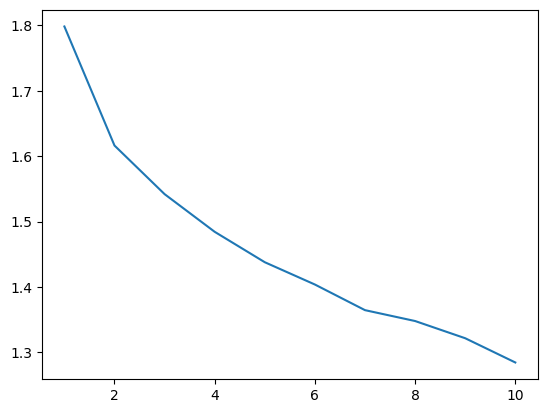

In [8]:
# Replacing Batch Norm+Swish w/ SeLU + LeCun initialization
import numpy as np

model3 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3*32*32, 100), nn.SELU(),
    nn.Linear(100,100), nn.SELU(),
    nn.Linear(100,100), nn.SELU(),
    nn.Linear(100,100), nn.SELU(),
    nn.Linear(100,100), nn.SELU(),
    nn.Linear(100,10)
)
for idx, module in model3.named_modules():
    if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, std=1.0/np.sqrt(module.weight.size(1)))
        nn.init.zeros_(module.bias)

all_imgs = torch.stack([img for img, _ in train_data])
mean = all_imgs.mean()
std = all_imgs.std()
imgs_normalized = (all_imgs - mean) / std
labels = torch.tensor([lab for img, lab in train_data])
train_data_normalized = torch.utils.data.TensorDataset(imgs_normalized, labels)

model3.to(device)
lr = .003
optimizer = torch.optim.NAdam(model3.parameters(), lr=lr)
xentropy = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(train_data_normalized, batch_size=32, shuffle=True)
losses = train(model3, optimizer, xentropy, train_loader, 10)
plt.plot([x[0] for x in losses], [x[1] for x in losses])
plt.show()

In [9]:
# Evaluation of Model 3
all_imgs = torch.stack([img for img, _ in valid_data])
imgs_normalized = (all_imgs - mean) / std
labels = torch.tensor([lab for img, lab in valid_data])
valid_data_normalized = torch.utils.data.TensorDataset(imgs_normalized, labels)

valid_loader = torch.utils.data.DataLoader(valid_data_normalized, batch_size=32, shuffle=True)
loss, accuracy = eval(model3, xentropy, valid_loader)
print("Model 3 Loss:", loss)
print("Model 3 Accuracy:", accuracy)

Model 3 Loss: 1.4799280561459291
Model 3 Accuracy: 0.4912


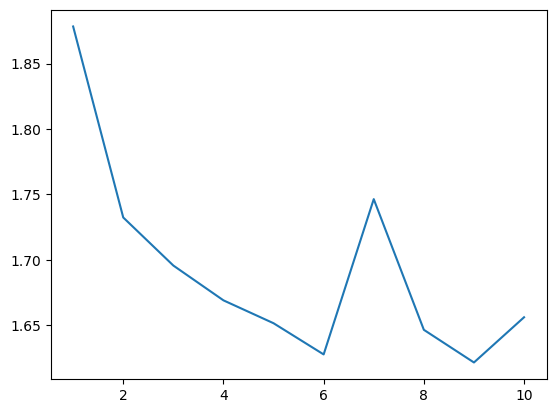

In [14]:
# Adding Alpha Dropout to Model 3

model3a = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3*32*32, 100), nn.SELU(), nn.AlphaDropout(.1),
    nn.Linear(100,100), nn.SELU(), nn.AlphaDropout(.1),
    nn.Linear(100,100), nn.SELU(), nn.AlphaDropout(.1),
    nn.Linear(100,100), nn.SELU(), nn.AlphaDropout(.1),
    nn.Linear(100,100), nn.SELU(), nn.AlphaDropout(.1),
    nn.Linear(100,10)
)
for idx, module in model3a.named_modules():
    if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, std=1.0/np.sqrt(module.weight.size(1)))
        nn.init.zeros_(module.bias)

model3a.to(device)
lr = .003
optimizer = torch.optim.NAdam(model3a.parameters(), lr=lr)
xentropy = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(train_data_normalized, batch_size=32, shuffle=True)
losses = train(model3a, optimizer, xentropy, train_loader, 10)
plt.plot([x[0] for x in losses], [x[1] for x in losses])
plt.show()

In [15]:
all_imgs = torch.stack([img for img, _ in valid_data])
imgs_normalized = (all_imgs - mean) / std
labels = torch.tensor([lab for img, lab in valid_data])
valid_data_normalized = torch.utils.data.TensorDataset(imgs_normalized, labels)

valid_loader = torch.utils.data.DataLoader(valid_data_normalized, batch_size=32, shuffle=True)
loss, accuracy = eval(model3a, xentropy, valid_loader)
print("Model 3a Loss:", loss)
print("Model 3a Accuracy:", accuracy)

Model 3a Loss: 1.8795754939887175
Model 3a Accuracy: 0.444


In [17]:
# Adding MC Dropout to Improve 3a

def evalMC(model, criterion, test_loader):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = []
            for i in range(100):
                y_pred.append(model(X_batch))
            y_pred = torch.stack(y_pred).mean(dim=0)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
            _, predicted = torch.max(y_pred, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total
    return avg_loss, accuracy

valid_loader = torch.utils.data.DataLoader(valid_data_normalized, batch_size=32, shuffle=True)
loss, accuracy = evalMC(model3a, xentropy, valid_loader)
print("Model 3b Loss:", loss)
print("Model 3b Accuracy:", accuracy)

Model 3b Loss: 1.5726136318437614
Model 3b Accuracy: 0.4464


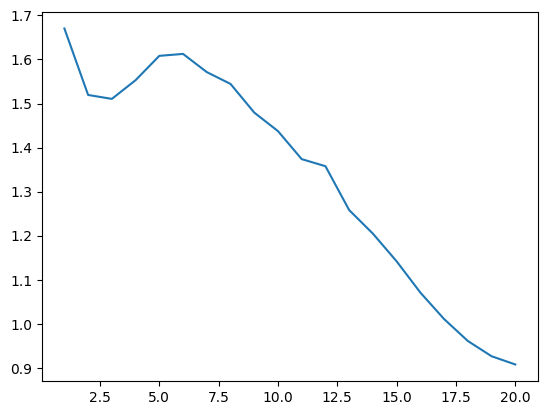

In [24]:
# Adding 1cycle scheduling to model 3

model3c = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3*32*32, 100), nn.SELU(),
    nn.Linear(100,100), nn.SELU(),
    nn.Linear(100,100), nn.SELU(),
    nn.Linear(100,100), nn.SELU(),
    nn.Linear(100,100), nn.SELU(),
    nn.Linear(100,10)
)
for idx, module in model3.named_modules():
    if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, std=1.0/np.sqrt(module.weight.size(1)))
        nn.init.zeros_(module.bias)

all_imgs = torch.stack([img for img, _ in train_data])
mean = all_imgs.mean()
std = all_imgs.std()
imgs_normalized = (all_imgs - mean) / std
labels = torch.tensor([lab for img, lab in train_data])
train_data_normalized = torch.utils.data.TensorDataset(imgs_normalized, labels)

def train(model, optimizer, scheduler, criterion, train_loader, n_epochs):
    model.train()
    loss_epochs = []
    for epoch in range(1, n_epochs+1):
        total_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            total_loss+=loss.item()
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
        loss_epochs.append((epoch, total_loss/len(train_loader)))
    return loss_epochs

model3c.to(device)
n_epochs = 20
optimizer = torch.optim.NAdam(model3c.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=.005, total_steps=n_epochs*len(train_loader))
xentropy = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(train_data_normalized, batch_size=32, shuffle=True)
losses = train(model3c, optimizer, scheduler, xentropy, train_loader, n_epochs)
plt.plot([x[0] for x in losses], [x[1] for x in losses])
plt.show()


In [25]:
all_imgs = torch.stack([img for img, _ in valid_data])
imgs_normalized = (all_imgs - mean) / std
labels = torch.tensor([lab for img, lab in valid_data])
valid_data_normalized = torch.utils.data.TensorDataset(imgs_normalized, labels)

valid_loader = torch.utils.data.DataLoader(valid_data_normalized, batch_size=32, shuffle=True)
loss, accuracy = eval(model3c, xentropy, valid_loader)
print("Model 3c Loss:", loss)
print("Model 3c Accuracy:", accuracy)

Model 3c Loss: 1.4929137586788008
Model 3c Accuracy: 0.5336


These models were suggested as exercises, below are my attempts.

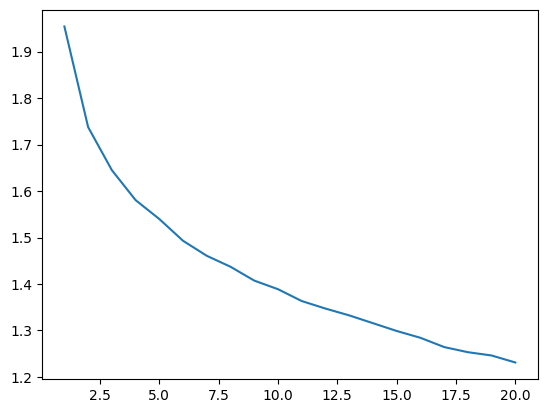

In [27]:
# Model 4: Layer Norm, Swish, AdamW optimizer

model4 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3*32*32, 100), nn.LayerNorm(100), nn.SiLU(),
    nn.Linear(100,100), nn.LayerNorm(100), nn.SiLU(),
    nn.Linear(100,100), nn.LayerNorm(100), nn.SiLU(),
    nn.Linear(100,100), nn.LayerNorm(100), nn.SiLU(),
    nn.Linear(100,100), nn.LayerNorm(100), nn.SiLU(),
    nn.Linear(100,10)
)
for idx, module in model4.named_modules():
    if isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight)
        nn.init.zeros_(module.bias)
        
def train(model, optimizer, criterion, train_loader, n_epochs):
    model.train()
    loss_epochs = []
    for epoch in range(1, n_epochs+1):
        total_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            total_loss+=loss.item()
            optimizer.step()
            optimizer.zero_grad()
        loss_epochs.append((epoch, total_loss/len(train_loader)))
    return loss_epochs

model4.to(device)
lr = .003
optimizer = torch.optim.AdamW(model4.parameters(), lr=lr)
xentropy = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
losses = train(model4, optimizer, xentropy, train_loader, 20)
plt.plot([x[0] for x in losses], [x[1] for x in losses])
plt.show()

In [29]:
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True)
loss, accuracy = eval(model4, xentropy, valid_loader)
print("Model 4 Loss:", loss)
print("Model 4 Accuracy:", accuracy)

Model 4 Loss: 1.4547849065938574
Model 4 Accuracy: 0.4882
